# ISA and combined loss - evaluating different $\alpha$

We've defined a new loss that is 

$\mathcal{L}_{tot} = \mathcal{L}_{BCE} + \alpha \cdot \mathcal{L}_{MSE}$ 

where BCE stands for binary cross entropy and MSE for mean squared error. $\alpha$ is for scaling. The BCE is supposed to separate features from a single picture into one picture each (e.g. each ring in a separate picture) while the MSE computes the properties of each feature (e.g. $x$, $y$ and $R$ of each ring). In this ring example $x$ and $y$ are computed with respect to the center-of-mass (regarding the hits) of each single-ring picture.

The goal of this notebook is 
1. to load the models for $\alpha = 1, 2$ at a lower epoch number (as we see unlearning for higher epochs, see Nicoles losses) and plot some example pictures. 
2. Think of a good metrix to evaluate the separation of the rings.

Let's get started!! :-) 

### Import, load model and data

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib.patches import Circle
import json

In [3]:
device = 'cpu'

Load configurations

In [4]:
cID_prev = 'isa-alpha1'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [5]:
torch_seed = 29082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

Load model and its weights

In [6]:
m = InvariantSlotAttention(**hps)

In [7]:
lastIter = 11000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 11000


<All keys matched successfully>

Load/generate some data

In [8]:
bs = 100
kwargs = cd['data']

X, Y, mask = make_batch(N_events=bs, **kwargs)

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/Invariant-Slot-Attention (ISA) methods/./../../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


### Evaluate the model

In [9]:
from train import hungarian_matching
import torch.nn.functional as F

k_slots=3
max_n_rings=2
resolution=(32,32)

In [10]:
alpha = cd['opt']['alpha']

In [11]:
with torch.no_grad():

    torch.manual_seed(torch_seed)
    queries, att, Y_pred = m(X)
         
    # Reshape the target mask to be flat in the pixels (same shape as att)
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

    # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    # Loss calc
    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

    Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean(axis=-1)

    # Calculate the loss
    print(l_bce.shape)
    print(l_mse.shape)
    li = l_bce + alpha*l_mse
    

torch.Size([100])
torch.Size([100])


Now let's histogram the loss!

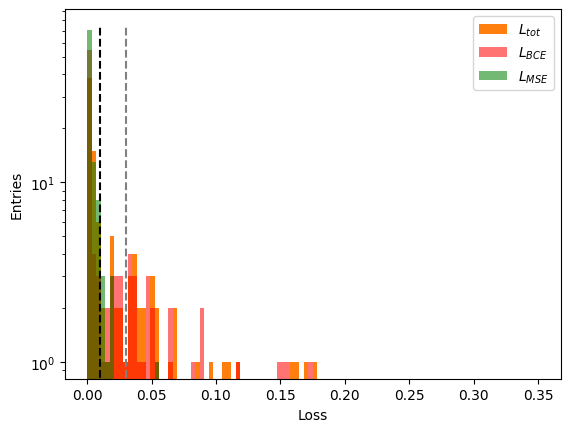

In [12]:

plt.hist(li.numpy(),100,color='C1', label="$L_{tot}$", range=(0, 0.35))
plt.hist(l_bce.numpy(),100,color='r', label="$L_{BCE}$", alpha=0.55, range=(0, 0.35))
plt.hist(l_mse.numpy(),100,color='green', label="$L_{MSE}$", alpha=0.55, range=(0, 0.35))
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.plot([.01]*2,ylim,'k--')
plt.plot([.03]*2,ylim,'grey',ls='--')

plt.legend()
plt.yscale("log")

plt.show()

### Looking at examples

Let's plot some example rings.

In [13]:
def plot_chosen_slots(losses, mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+2,figsize=(3*(n_rings + 2) ,2.5))

    for k,v in losses.items():
        axs[0].plot(v,label=k)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        

    # Add on the target image
    axi = axs[1]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[2:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    #if figname:
    #    plt.savefig(figname)

    plt.show()
    plt.close()

In [14]:
f = open(f'./../../code/models/{cID_prev}/loss.json')
# returns JSON object as a dictionary
losses = json.load(f)

In [15]:
iEvt = 8

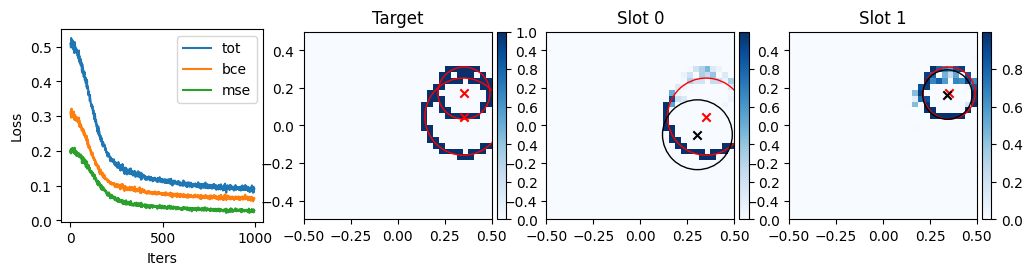

In [16]:
plot_chosen_slots(losses,
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])

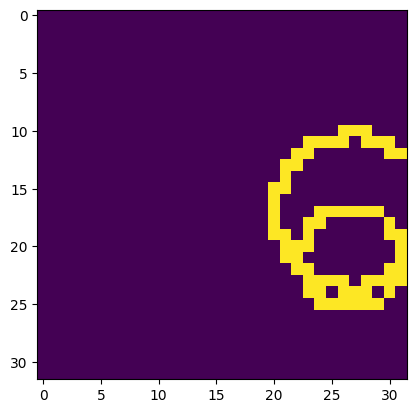

In [17]:
 plt.imshow(mask[iEvt].sum(axis=0))

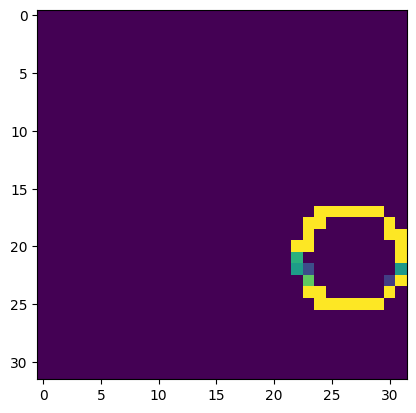

In [18]:
 plt.imshow(mask[iEvt][0])

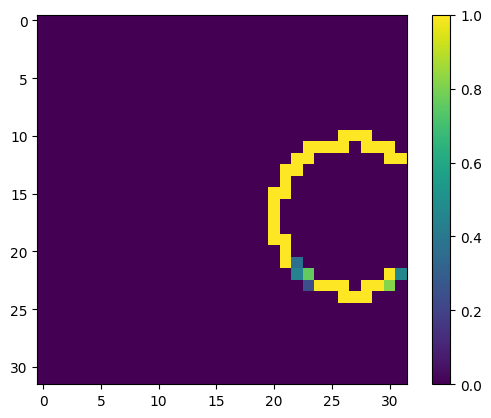

In [19]:
plt.imshow(mask[iEvt][1])
plt.colorbar()

# Metrix: Use KL-divergence

This is 

$KL(p,q) = \sum_i p_i \log{\frac{p_i}{q_i}} = \sum_i p_i \log{p_i} - \sum_i p_i \log{q_i}$

and is a extension of the BCE as mixed terms (if $p_i$ not binary) get subtracted too. This should be a metrix that works for rings and clusters. 
Check [this page](https://pytorch.org/docs/stable/generated/torch.nn.functional.kl_div.html) for the pytorch doc.

In [20]:
l_kl = F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

Sanity-check: does the KL-divergence look similar to BCE? Only ~10% difference is suspected due to overlapping rings.

In [38]:
len(l_kl)

100

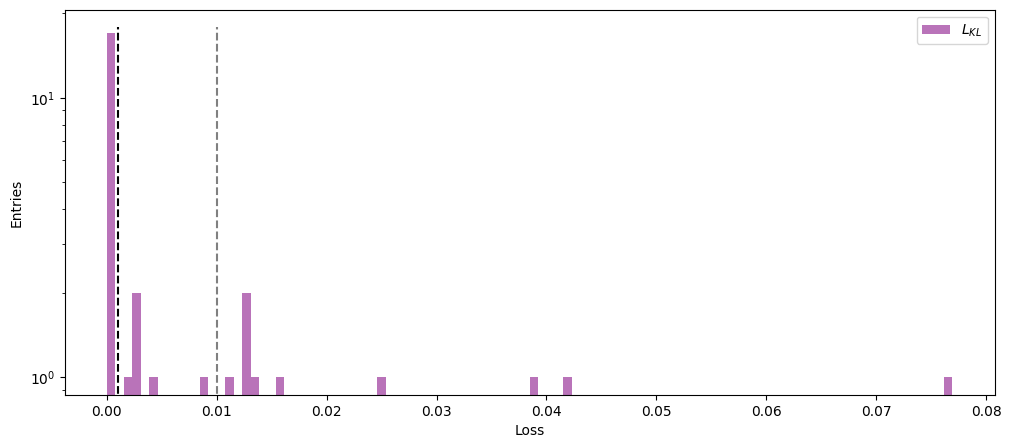

In [41]:
plt.hist(l_kl.numpy(),100,color='purple', label="$L_{KL}$", alpha=0.55)


#plt.hist(l_bce.numpy(),100,color='r', label="$L_{BCE}$", alpha=0.55, range=(0, 0.35))
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.plot([.001]*2,ylim,'k--')
plt.plot([.01]*2,ylim,'grey',ls='--')

plt.legend()
plt.yscale("log")

plt.show()

Let's look at some examples for good and bad separation!

In [22]:
mi = l_kl < 0.001 # good events
torch.sum(mi)
mj = l_kl > 0.01 # bad events
torch.sum(mj)

good_imgs = mask[mi].sum(axis=1)
bad_imgs  = mask[mj].sum(axis=1)

In [23]:
good_imgs.shape

torch.Size([17, 32, 32])

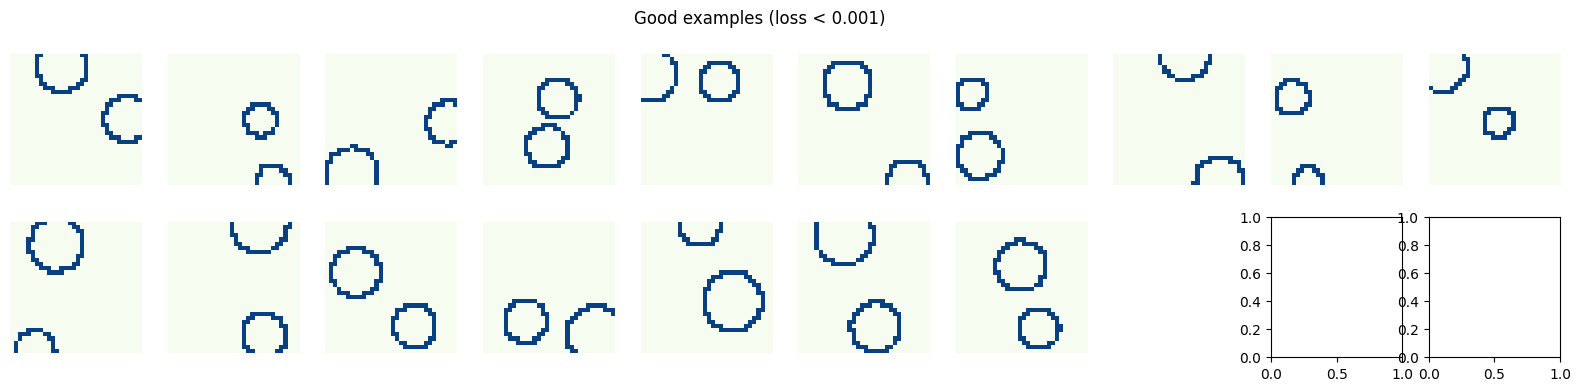

In [33]:
# Good exs
nrows = 2
ncols = 10

fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*2,nrows*2))

for i, ax_i in enumerate(axes):

    for j, ax in enumerate(ax_i):

        k = i * ncols + j 
        ax.axis('off')
        
        if k >= len(good_imgs):
            break
        
        im = ax.imshow(good_imgs[k].numpy(),cmap='GnBu')

        
        # ax.set_title(0,0,f'evt={k}',transform=ax_ij.transAxes) 

fig.suptitle('Good examples (loss < 0.001)',va='top')
plt.show()

In [25]:
bad_imgs.shape

torch.Size([9, 32, 32])

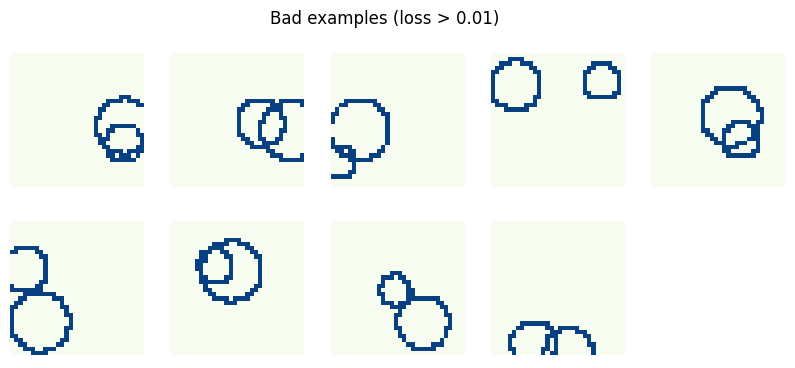

In [36]:
# Bad exs
nrows = 2
ncols = 5

fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*2,nrows*2))

for i, ax_i in enumerate(axes):

    for j, ax in enumerate(ax_i):

        k = i * ncols + j 
        ax.axis('off')
        
        if k >= len(bad_imgs):
            break
        
        im = ax.imshow(bad_imgs[k].numpy(),cmap='GnBu')

        
        # ax.set_title(0,0,f'evt={k}',transform=ax_ij.transAxes) 

fig.suptitle('Bad examples (loss > 0.01)',va='top')
plt.show()

## Let's have a closer look at these "bad" separated images

In [27]:
def plot_chosen_slots_only(mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+1,figsize=(3*(n_rings + 2) ,2.5))
   
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[0:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        

    # Add on the target image
    axi = axs[0]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[1:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    #if figname:
    #    plt.savefig(figname)

    plt.show()
    plt.close()

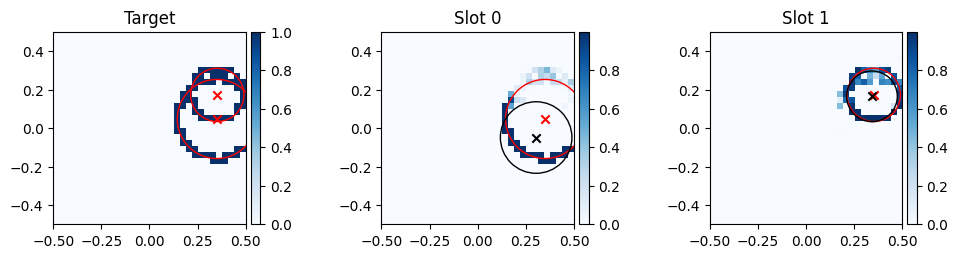

In [28]:
plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])

KL:  tensor(0.0250)


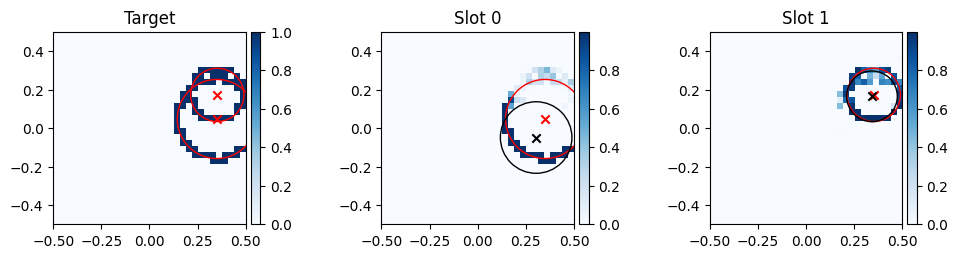

KL:  tensor(0.0423)


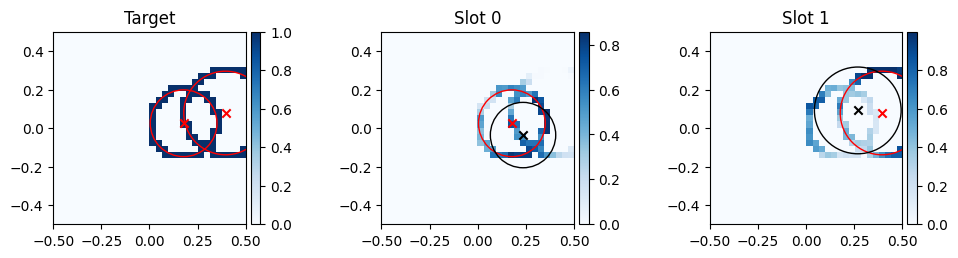

KL:  tensor(0.0157)


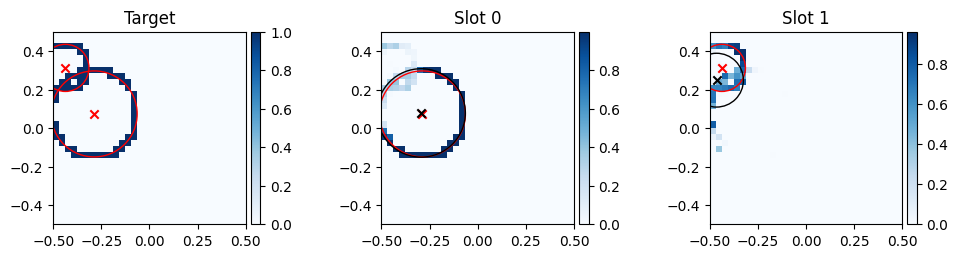

KL:  tensor(0.0123)


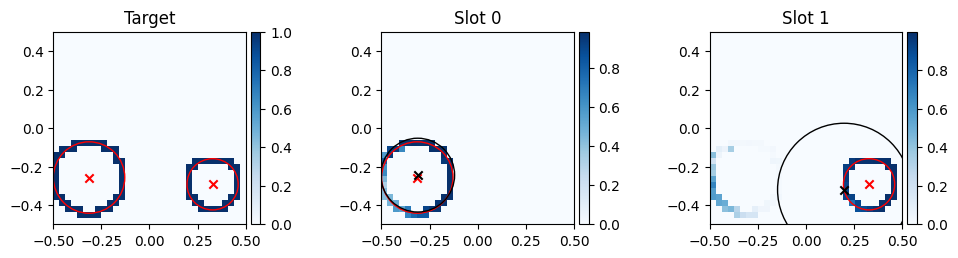

KL:  tensor(0.0769)


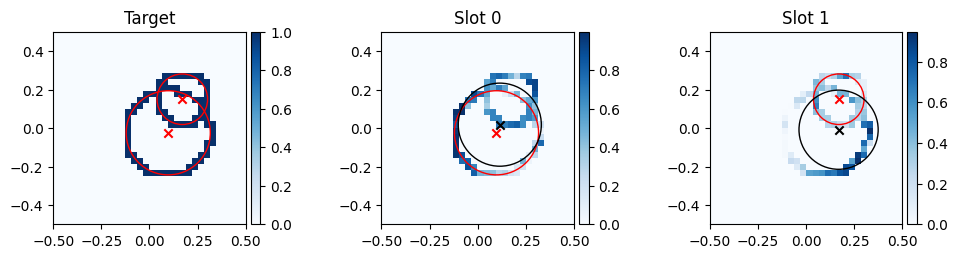

KL:  tensor(0.0131)


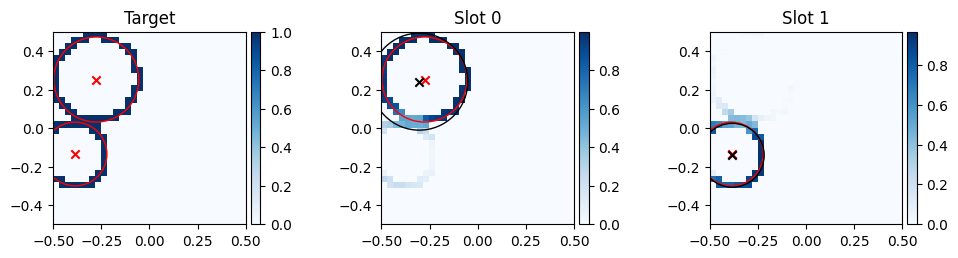

KL:  tensor(0.0388)


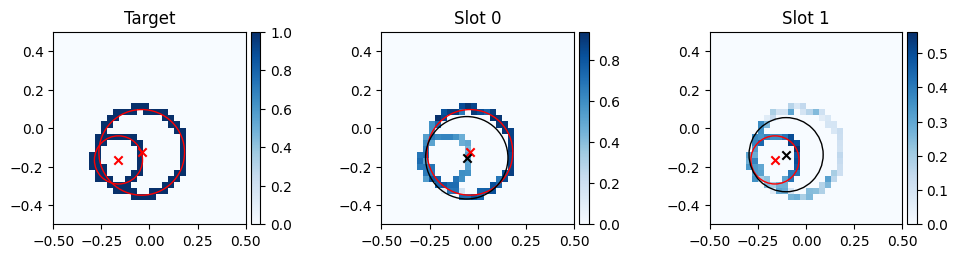

KL:  tensor(0.0112)


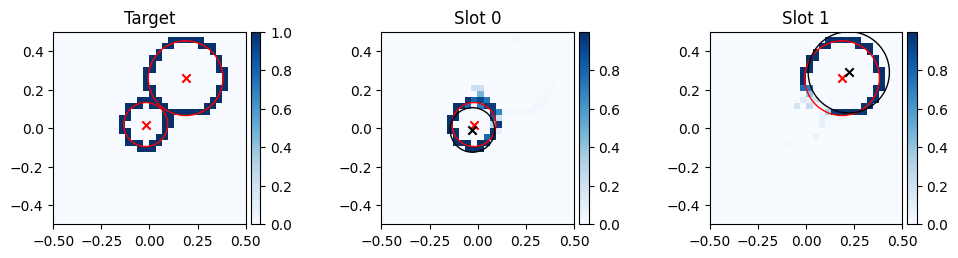

KL:  tensor(0.0126)


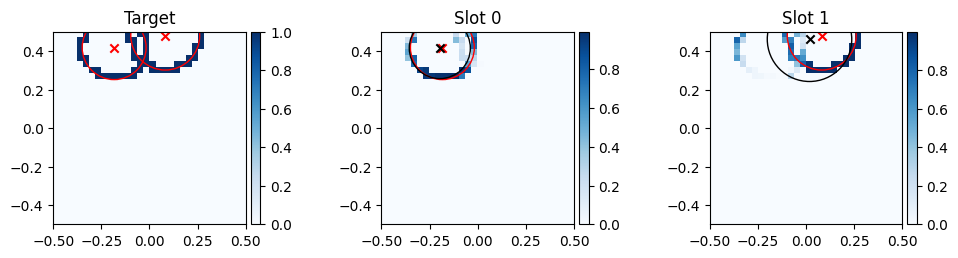

In [29]:
for count, k in enumerate(np.where(l_kl > 0.01)[0]):
    iEvt = k
    print("KL: ", l_kl[iEvt])
    plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])
    if count>15:
        break

Good examples:

KL:  tensor(0.0004)


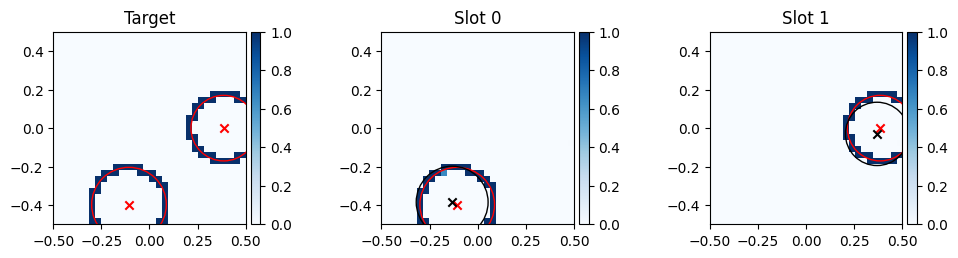

KL:  tensor(4.5819e-06)


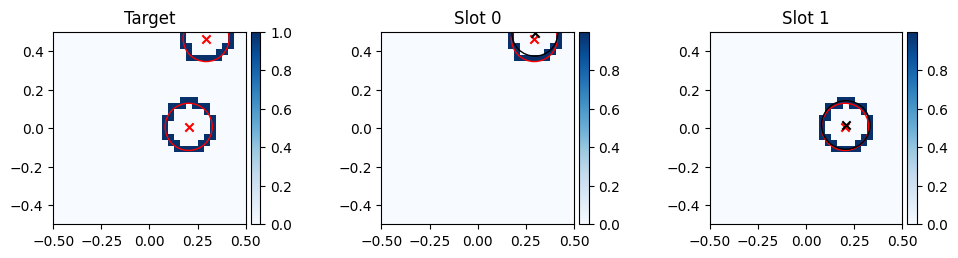

KL:  tensor(1.5552e-05)


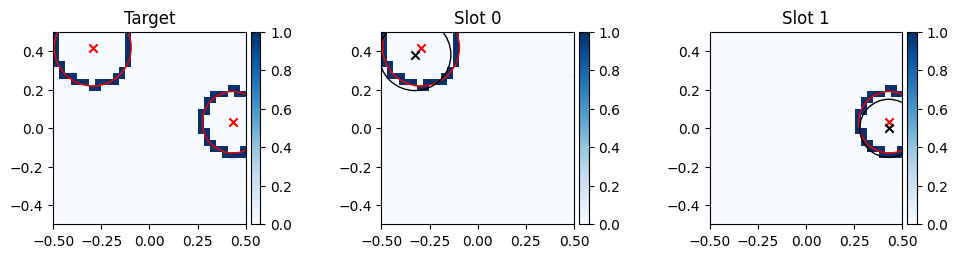

KL:  tensor(8.8854e-05)


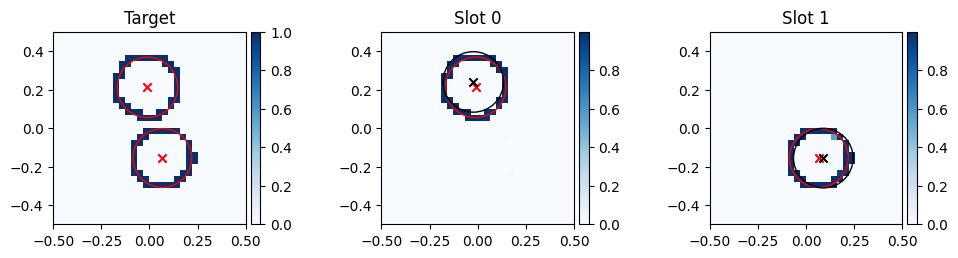

KL:  tensor(9.2207e-05)


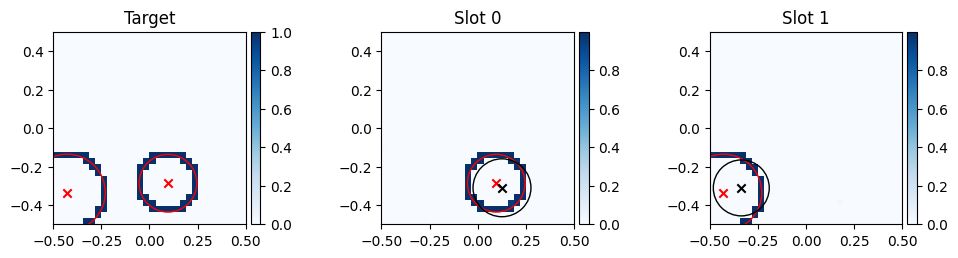

KL:  tensor(2.0770e-05)


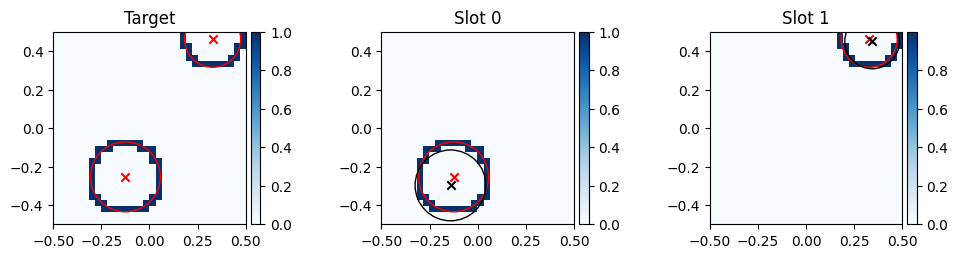

KL:  tensor(8.8576e-06)


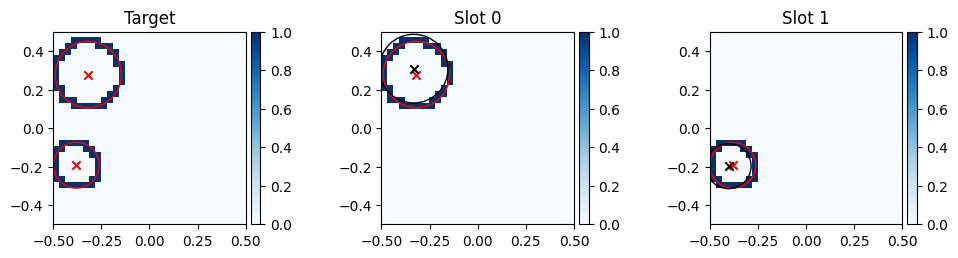

KL:  tensor(6.8400e-06)


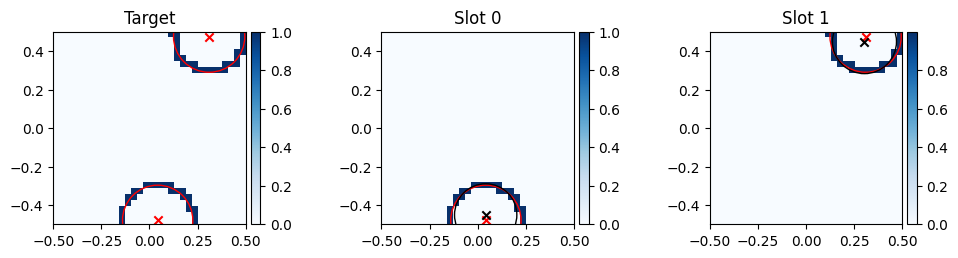

KL:  tensor(2.8290e-07)


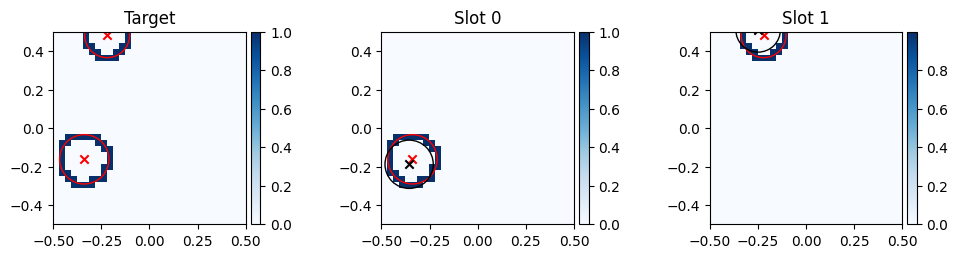

KL:  tensor(1.6844e-05)


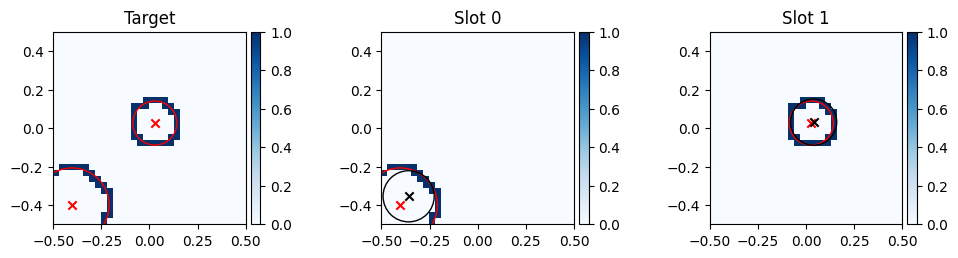

KL:  tensor(1.7729e-05)


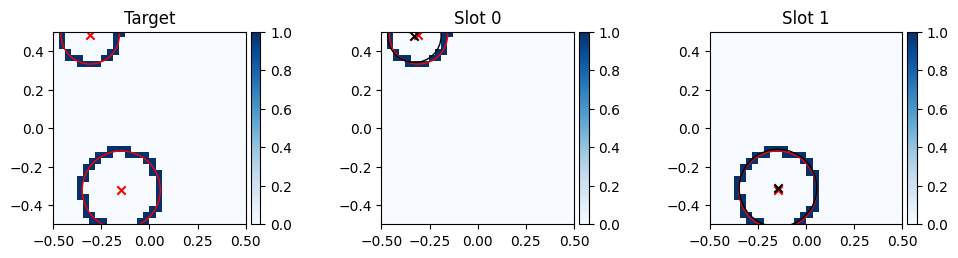

KL:  tensor(1.1482e-05)


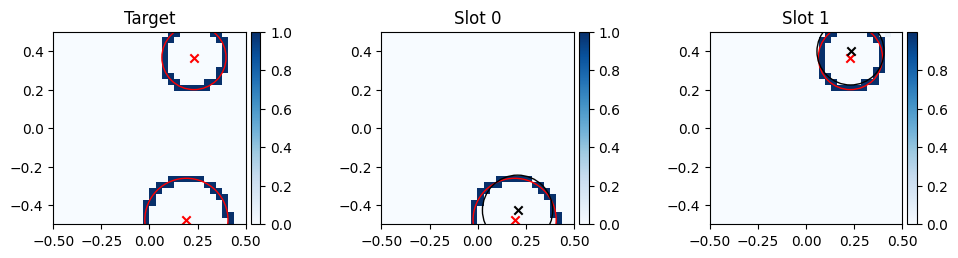

KL:  tensor(3.7291e-05)


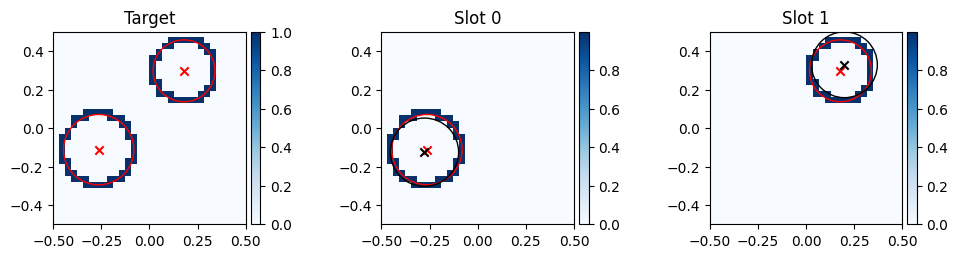

KL:  tensor(3.9691e-05)


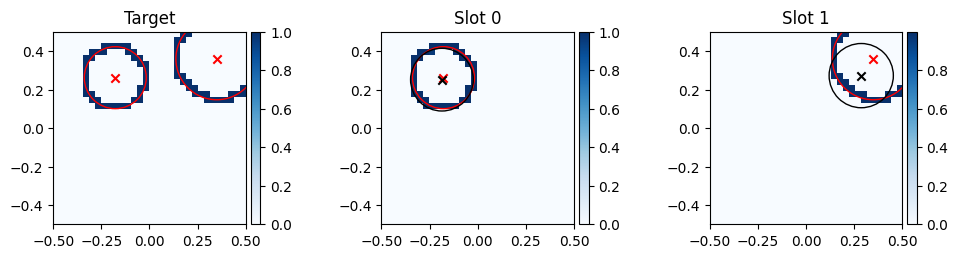

KL:  tensor(3.4810e-05)


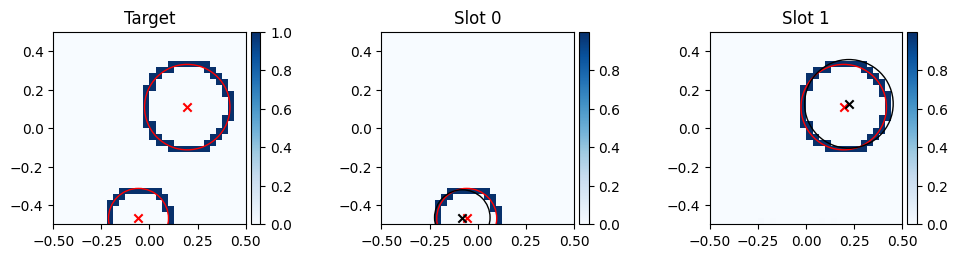

KL:  tensor(0.0005)


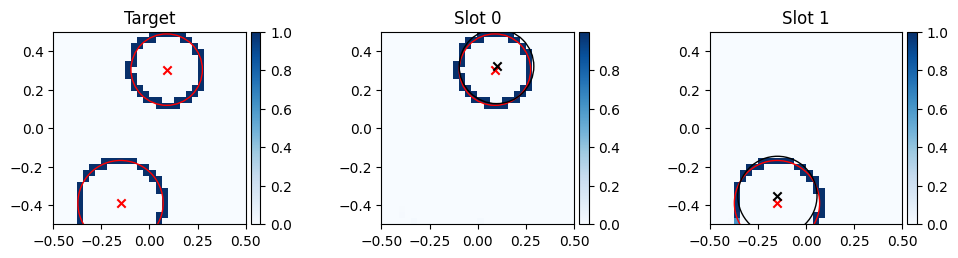

KL:  tensor(3.4707e-05)


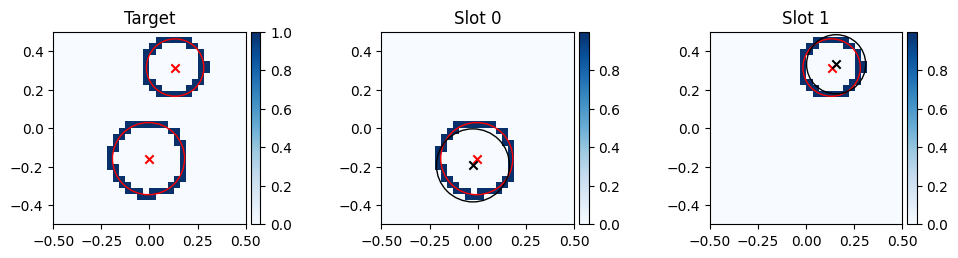

In [30]:
for count, k in enumerate(np.where(l_kl < 0.001)[0]):
    iEvt = k
    print("KL: ", l_kl[iEvt])
    plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])
    if count>15:
        break

In [31]:
plt.rcParams["figure.figsize"] = (12,5)
for k,v in losses.items():
    print(np.argmin(v))
    print("now: ", v[5000])
    print("best: ", v[11194])
    plt.plot(v,label=k)
    plt.xlabel('Iters')
    plt.ylabel('Loss')
    plt.legend()

845


IndexError: list index out of range

Ok reload this notebook for model at epoch 11194!! 